**Set A**

**1) Generate an image by using Restricted Boltzmann Machine using a real
image dataset (Use MNIST dataset). Use the DataLoader class of the
torch.utils.data library to load training and testing datasets , set the batch size
to 64 and apply the transformations.Visualize the real and generated image.**

Epoch 1, Loss: 0.2155
Epoch 2, Loss: 0.3409
Epoch 3, Loss: 0.4581
Epoch 4, Loss: 0.4981
Epoch 5, Loss: 0.5131


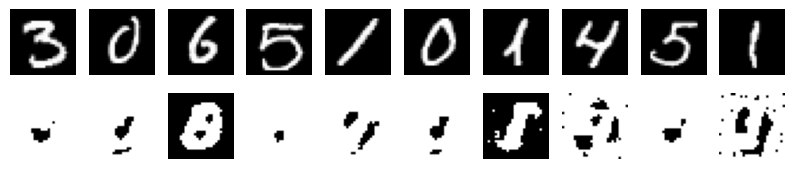

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Load MNIST dataset
batch_size = 64
transform = transforms.ToTensor()  # keep image shape intact for visualization

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# RBM Model
class RBM(nn.Module):
    def __init__(self, n_visible=784, n_hidden=256):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)  # weight matrix
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))               # hidden bias
        self.v_bias = nn.Parameter(torch.zeros(n_visible))              # visible bias

    def sample_h(self, v):
        prob_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v):
        prob_h, h = self.sample_h(v)
        prob_v, v_recon = self.sample_v(h)
        return v_recon


# Training Loop
rbm = RBM(n_visible=784, n_hidden=256)
optimizer = torch.optim.SGD(rbm.parameters(), lr=0.1)

epochs = 5
for epoch in range(epochs):
    loss = 0
    for batch, _ in train_loader:
        v0 = batch.view(-1, 28*28)  # flatten here
        # Positive phase
        prob_h0, h0 = rbm.sample_h(v0)
        # Negative phase
        prob_v, vk = rbm.sample_v(h0)
        prob_hk, hk = rbm.sample_h(vk)

        # Update weights
        rbm.W.grad = -(torch.matmul(v0.t(), prob_h0) - torch.matmul(vk.t(), prob_hk)).t() / batch_size
        rbm.v_bias.grad = torch.mean(v0 - vk, dim=0)
        rbm.h_bias.grad = torch.mean(prob_h0 - prob_hk, dim=0)

        optimizer.step()

        loss += torch.mean((v0 - vk) ** 2).item()

    print(f"Epoch {epoch+1}, Loss: {loss/len(train_loader):.4f}")


# Visualization
def show_images(real, generated, n=10):
    plt.figure(figsize=(n, 2))
    for i in range(n):
        # Real image
        plt.subplot(2, n, i+1)
        plt.imshow(real[i].squeeze().numpy(), cmap="gray")
        plt.axis("off")
        # Generated image
        plt.subplot(2, n, n+i+1)
        plt.imshow(generated[i].view(28, 28).detach().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()


# Get one batch
real_batch, _ = next(iter(train_loader))
real_images = real_batch[:10]

# Generate images from RBM
reconstructed = rbm(real_images.view(-1, 28*28))  # flatten here

# Show real vs generated
show_images(real_images, reconstructed, n=10)


**2) Write a python program to design a Restricted Boltzmann Machine for
predicting collaboration.**

In [ ]:
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import random

# Download MovieLens 100K if needed
ML_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 100K dataset...")
    zip_path = "ml-100k.zip"
    urllib.request.urlretrieve(ML_URL, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(".")
    os.remove(zip_path)
    print("Downloaded and extracted ml-100k.")

# Load ratings and create user-item matrix
# Ratings file format: user id | item id | rating | timestamp
ratings_path = os.path.join(DATA_DIR, "u.data")
ratings = pd.read_csv(ratings_path, sep="\t", header=None,
                      names=["user_id", "item_id", "rating", "timestamp"])

n_users = ratings.user_id.nunique()
n_items = ratings.item_id.nunique()
print(f"Users: {n_users}, Items: {n_items}")

# Convert to 0-indexed user/item
ratings["user_id"] -= 1
ratings["item_id"] -= 1

# Binarize: liked = rating >= 4
ratings["liked"] = (ratings["rating"] >= 4).astype(int)

# Build per-user lists of (item,liked)
user_group = ratings.groupby("user_id").apply(lambda df: df[["item_id", "liked"]].values.tolist())
user_ratings = {u: [(int(it), int(l)) for it, l in vals] for u, vals in user_group.items()}


# Create train/test split (leave-one-out): for each user keep 1 known rating for test
train_matrix = np.zeros((n_users, n_items), dtype=np.float32)  # 1 = liked, 0 = unknown/not liked
test_pairs = []  # (user, item, liked)

random.seed(42)
for u in range(n_users):
    items = user_ratings[u]
    # choose one rated item for test (if user has at least 1 rating)
    if len(items) == 0:
        continue
    test_idx = random.randrange(len(items))
    for i, (item, liked) in enumerate(items):
        if i == test_idx:
            test_pairs.append((u, item, liked))
        else:
            # Keep only positive (liked) signals in training matrix to model implicit feedback
            if liked == 1:
                train_matrix[u, item] = 1.0

# train_matrix will not include negative signals explicitly; unknowns remain 0.
print(f"Train matrix shape: {train_matrix.shape}, Test pairs: {len(test_pairs)}")


#  RBM Model (binary visible, binary hidden)
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        # Parameters
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        # v: (batch, n_visible) values in [0,1]
        wx = F.linear(v, self.W, self.h_bias)  # (batch, n_hidden)
        ph = torch.sigmoid(wx)
        return ph, torch.bernoulli(ph)

    def sample_v(self, h):
        wx = F.linear(h, self.W.t(), self.v_bias)  # (batch, n_visible)
        pv = torch.sigmoid(wx)
        return pv, torch.bernoulli(pv)

    def forward(self, v0, k=1):
        # Contrastive Divergence CD-k
        v = v0
        ph0, h = self.sample_h(v)
        for _ in range(k):
            pv, v = self.sample_v(h)
            ph, h = self.sample_h(v)
        return v, ph0, ph, pv

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        wx_b = F.linear(v, self.W.t(), self.h_bias)  # (batch, n_hidden)
        hidden_term = torch.sum(torch.log1p(torch.exp(wx_b)), dim=1)
        return -vbias_term - hidden_term


# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_visible = n_items
n_hidden = 128
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden).to(device)

# Create DataLoader from train_matrix rows (each user is a training example)
X_train = torch.tensor(train_matrix, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)

optimizer = torch.optim.SGD(rbm.parameters(), lr=0.1, momentum=0.9)
epochs = 15
k = 1  # CD-1

print("Training RBM...")
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_tuple in train_loader:
        v0 = batch_tuple[0].to(device)
        # skip users with all zeros (no positive training signals)
        if v0.sum(dim=1).eq(0).all():
            continue

        # Positive phase
        ph0, _ = rbm.sample_h(v0)
        # Negative phase via CD-k
        vk = v0.clone()
        phk = None
        for _ in range(k):
            pvk, hk = rbm.sample_v(torch.bernoulli(ph0))
            phk, _ = rbm.sample_h(pvk)
            vk = pvk

        # Compute gradients via CD
        # dW ~ <v0 * ph0> - <vk * phk>
        positive_grad = torch.matmul(ph0.t(), v0)  # (n_hidden, n_visible)
        negative_grad = torch.matmul(phk.t(), vk)

        # Parameter updates (manual)
        batch_size = v0.size(0)
        grad_W = (positive_grad - negative_grad) / batch_size
        grad_vb = torch.mean(v0 - vk, dim=0)
        grad_hb = torch.mean(ph0 - phk, dim=0)

        # Apply gradients (SGD step)
        optimizer.zero_grad()
        # Manually set gradients on parameters
        rbm.W.grad = -grad_W  # negative because optimizer does gradient descent
        rbm.v_bias.grad = -grad_vb
        rbm.h_bias.grad = -grad_hb
        optimizer.step()

        # track reconstruction loss
        epoch_loss += torch.mean((v0 - vk) ** 2).item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

print("Training done.")

# Prediction / Recommendation
# For each test pair (user, item, liked), we compute probabilities for all items
# given the user's visible vector and then rank items. Evaluate whether held-out item is in top-K.
def recommend_for_user(rbm_model, user_vector, top_k=10, device='cpu'):
    """
    user_vector: 1D numpy array or tensor of size n_items with training-known positives =1, else 0
    Returns top_k item indices ordered by reconstructed probability (descending).
    """
    rbm_model.eval()
    with torch.no_grad():
        v = torch.tensor(user_vector.reshape(1, -1), dtype=torch.float32).to(device)
        # compute hidden probabilities
        ph, _ = rbm_model.sample_h(v)
        # compute visible probabilities from ph
        pv = torch.sigmoid(F.linear(ph, rbm_model.W.t(), rbm_model.v_bias))
        probs = pv.cpu().numpy().flatten()
    # mask already-known training positives
    probs_masked = probs.copy()
    probs_masked[user_vector == 1] = -1.0  # exclude known positives from recommendation
    top_items = np.argsort(-probs_masked)[:top_k]
    return top_items, probs

# Evaluate hit-rate @ K and precision@K
K = 10
hits = 0
precision_sum = 0.0
num_evaluated = 0

for (u, item, liked) in test_pairs:
    user_vec = train_matrix[u].copy()  # use train vector (without the test item)
    top_items, probs = recommend_for_user(rbm, user_vec, top_k=K, device=device)
    num_evaluated += 1
    # Hit if held-out test item is in top-K
    if item in top_items:
        hits += 1
    # Precision: fraction of top-K that are actual liked items in original full data
    # For that, we check original ratings list
    actual_likes = {it for it, l in user_ratings[u] if l == 1}
    prec_k = len([i for i in top_items if i in actual_likes]) / K
    precision_sum += prec_k

hit_rate = hits / num_evaluated
mean_precision = precision_sum / num_evaluated
print(f"Evaluation (leave-one-out) over {num_evaluated} users: HitRate@{K} = {hit_rate:.4f}, Precision@{K} = {mean_precision:.4f}")


# Show a small example recommendation
uid = 10
user_vec = train_matrix[uid]
top_items, probs = recommend_for_user(rbm, user_vec, top_k=10, device=device)
print(f"Top-10 recommended item IDs for user {uid}: {top_items}")
# You can map item IDs to movie titles using u.item if desired
item_titles = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep="|", header=None, encoding='latin-1', usecols=[0,1], names=['id','title'])
mapping = {int(row[0])-1: row[1] for idx,row in item_titles.iterrows()}
print("Top-10 movie titles (if available):")
for it in top_items:
    print(mapping.get(it, f"Item {it}"))


Downloaded and extracted ml-100k.
Users: 943, Items: 1682


/tmp/ipython-input-263113535.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_group = ratings.groupby("user_id").apply(lambda df: df[["item_id", "liked"]].values.tolist())


Train matrix shape: (943, 1682), Test pairs: 943
Training RBM...
Epoch 1/15, Loss: 0.075362
Epoch 2/15, Loss: 0.030124
Epoch 3/15, Loss: 0.027848
Epoch 4/15, Loss: 0.027386
Epoch 5/15, Loss: 0.026891
Epoch 6/15, Loss: 0.026322
Epoch 7/15, Loss: 0.025952
Epoch 8/15, Loss: 0.025604
Epoch 9/15, Loss: 0.025243
Epoch 10/15, Loss: 0.025016
Epoch 11/15, Loss: 0.024868
Epoch 12/15, Loss: 0.024479
Epoch 13/15, Loss: 0.024230
Epoch 14/15, Loss: 0.023930
Epoch 15/15, Loss: 0.023711
Training done.
Evaluation (leave-one-out) over 943 users: HitRate@10 = 0.2036, Precision@10 = 0.0161
Top-10 recommended item IDs for user 10: [ 97 215  68  63 659  11 142 274 196 173]
Top-10 movie titles (if available):
Silence of the Lambs, The (1991)
When Harry Met Sally... (1989)
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Fried Green Tomatoes (1991)
Usual Suspects, The (1995)
Sound of Music, The (1965)
Sense and Sensibility (1995)
Graduate, The (1967)
Raiders of the Lost Ark (1981)


/tmp/ipython-input-263113535.py:232: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mapping = {int(row[0])-1: row[1] for idx,row in item_titles.iterrows()}


**3) Implement Deep Belief network using Restricted RBM to create an effective
stack of models to perform digit classification.**

Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.33MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.60MB/s]



Pretraining RBM 1/2
RBM epoch 1/5, recon_loss: 0.075492
RBM epoch 2/5, recon_loss: 0.053139
RBM epoch 3/5, recon_loss: 0.048202
RBM epoch 4/5, recon_loss: 0.045584
RBM epoch 5/5, recon_loss: 0.043988

Pretraining RBM 2/2
RBM epoch 1/5, recon_loss: 0.068541
RBM epoch 2/5, recon_loss: 0.048023
RBM epoch 3/5, recon_loss: 0.044418
RBM epoch 4/5, recon_loss: 0.042612
RBM epoch 5/5, recon_loss: 0.041576

Starting supervised fine-tuning of DBN
Supervised epoch 1/8, loss=0.529163, test_acc=95.82%
Supervised epoch 2/8, loss=0.111416, test_acc=97.04%
Supervised epoch 3/8, loss=0.076024, test_acc=97.46%
Supervised epoch 4/8, loss=0.055491, test_acc=97.72%
Supervised epoch 5/8, loss=0.041524, test_acc=97.84%
Supervised epoch 6/8, loss=0.031048, test_acc=97.97%
Supervised epoch 7/8, loss=0.023309, test_acc=98.03%
Supervised epoch 8/8, loss=0.017119, test_acc=98.04%

Final Test Accuracy: 98.04%

Predictions on sample images:


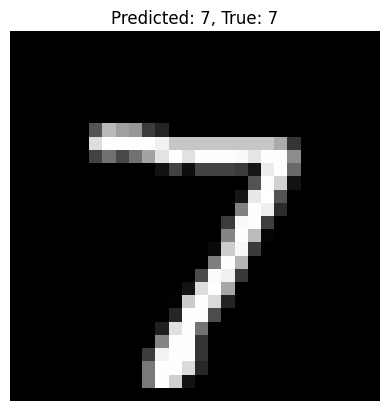

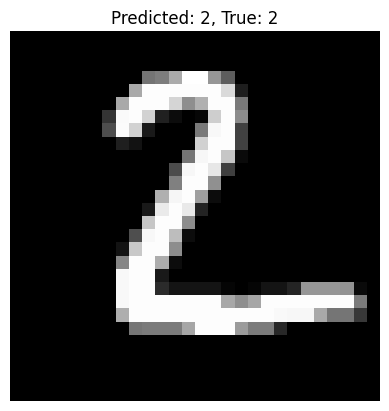

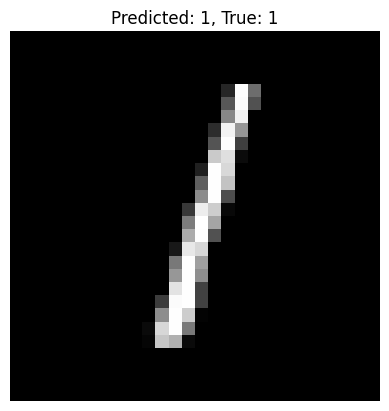

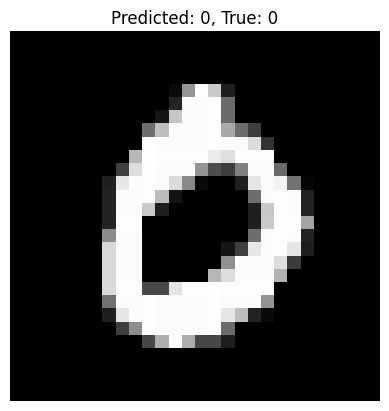

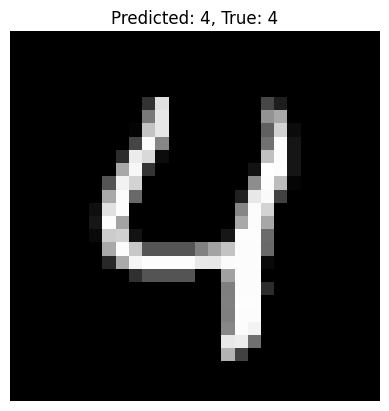

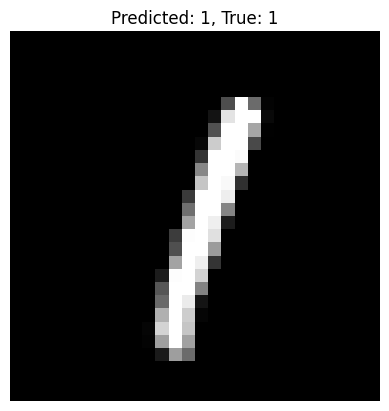

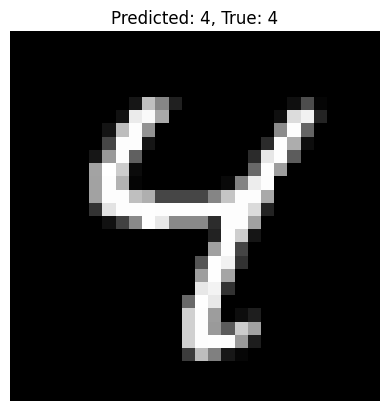

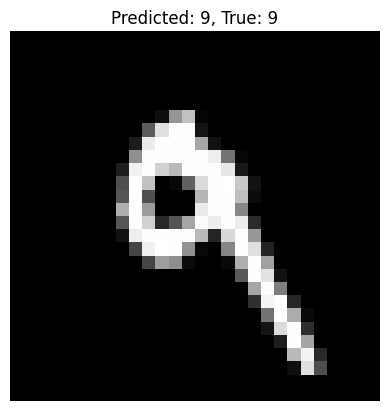

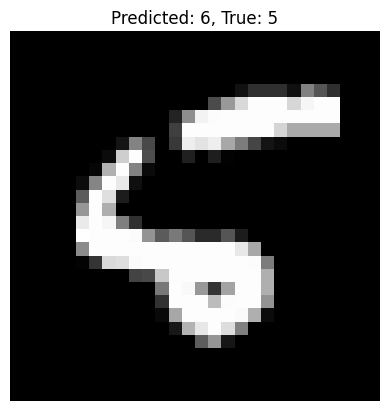

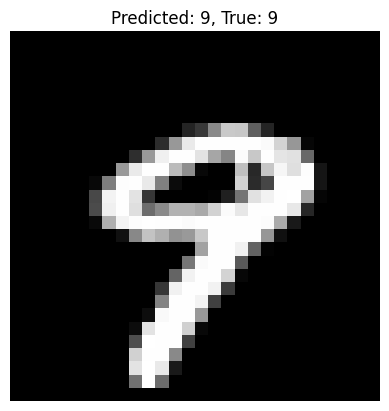

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# RBM (Bernoulli visible & hidden)
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        ph = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return ph, torch.bernoulli(ph)

    def sample_v(self, h):
        pv = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return pv, torch.bernoulli(pv)

    def gibbs_sample(self, v0, k=1):
        ph0, _ = self.sample_h(v0)
        vk = v0
        phk = None
        for _ in range(k):
            h = torch.bernoulli(ph0)
            pvk, vk = self.sample_v(h)
            phk, _ = self.sample_h(vk)
            ph0 = phk
        return vk, ph0, phk

# DBN Classifier
class DBNClassifier(nn.Module):
    def __init__(self, rbm_layers, n_classes=10):
        super().__init__()
        self.linears = nn.ModuleList()
        for rbm in rbm_layers:
            linear = nn.Linear(rbm.n_visible, rbm.n_hidden)
            linear.weight.data = rbm.W.data.clone()
            linear.bias.data = rbm.h_bias.data.clone()
            self.linears.append(linear)
        self.classifier = nn.Linear(rbm_layers[-1].n_hidden, n_classes)

    def forward(self, x):
        for linear in self.linears:
            x = torch.sigmoid(linear(x))
        return self.classifier(x)

# Pretraining RBM
def pretrain_rbm(rbm, data_loader, device='cpu', epochs=5, lr=0.1, k=1):
    rbm.to(device)
    optimizer = optim.SGD(rbm.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0
        for batch_data in data_loader:
            if isinstance(batch_data, (list, tuple)):
                v0 = batch_data[0]
            else:
                v0 = batch_data
            v0 = v0.view(v0.size(0), -1).to(device)
            if v0.size(0) == 0:
                continue

            ph0 = torch.sigmoid(F.linear(v0, rbm.W, rbm.h_bias))
            h_sample = torch.bernoulli(ph0)
            vk = v0
            phk = None
            for _ in range(k):
                pvk = torch.sigmoid(F.linear(h_sample, rbm.W.t(), rbm.v_bias))
                vk = torch.bernoulli(pvk)
                phk = torch.sigmoid(F.linear(vk, rbm.W, rbm.h_bias))
                h_sample = torch.bernoulli(phk)

            positive_grad = torch.matmul(ph0.t(), v0)
            negative_grad = torch.matmul(phk.t(), vk)
            batch_size = v0.size(0)
            grad_W = (positive_grad - negative_grad) / batch_size
            grad_vb = torch.mean(v0 - vk, dim=0)
            grad_hb = torch.mean(ph0 - phk, dim=0)

            optimizer.zero_grad()
            rbm.W.grad = -grad_W
            rbm.v_bias.grad = -grad_vb
            rbm.h_bias.grad = -grad_hb
            optimizer.step()

            epoch_loss += torch.mean((v0 - vk) ** 2).item()
            n_batches += 1

        print(f"RBM epoch {epoch+1}/{epochs}, recon_loss: {epoch_loss / n_batches:.6f}")

# Supervised fine-tuning
def train_dbn_supervised(dbn, train_loader, test_loader, device='cpu', epochs=10, lr=1e-3):
    dbn.to(device)
    optimizer = optim.Adam(dbn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        dbn.train()
        total_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            labels = labels.to(device)
            logits = dbn(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        acc = evaluate_dbn(dbn, test_loader, device)
        print(f"Supervised epoch {epoch+1}/{epochs}, loss={total_loss/len(train_loader):.6f}, test_acc={acc*100:.2f}%")

# Evaluation
def evaluate_dbn(dbn, data_loader, device='cpu'):
    dbn.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            labels = labels.to(device)
            logits = dbn(imgs)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total if total > 0 else 0.0

# Prediction + display
def predict_and_show(dbn, test_loader, device='cpu', num_samples=5):
    dbn.eval()
    imgs_shown = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            logits = dbn(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            imgs = imgs.view(-1, 1, 28, 28).cpu().numpy()
            for i in range(len(imgs)):
                plt.imshow(imgs[i][0], cmap="gray")
                plt.title(f"Predicted: {preds[i]}, True: {labels[i].item()}")
                plt.axis("off")
                plt.show()
                imgs_shown += 1
                if imgs_shown >= num_samples:
                    return

# Main
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    batch_size = 128
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=1000, shuffle=False)

    rbm1 = RBM(n_visible=28*28, n_hidden=512)
    rbm2 = RBM(n_visible=512, n_hidden=256)

    print("\nPretraining RBM 1/2")
    pretrain_rbm(rbm1, train_loader, device=device, epochs=5, lr=0.1, k=1)

    features = []
    with torch.no_grad():
        for imgs, _ in train_loader:
            v = imgs.view(imgs.size(0), -1).to(device)
            ph = torch.sigmoid(F.linear(v, rbm1.W, rbm1.h_bias))
            features.append(ph.cpu())
    features = torch.cat(features, dim=0)

    rbm2_dataset = TensorDataset(features)
    rbm2_loader = DataLoader(rbm2_dataset, batch_size=batch_size, shuffle=True)

    print("\nPretraining RBM 2/2")
    pretrain_rbm(rbm2, rbm2_loader, device=device, epochs=5, lr=0.1, k=1)

    dbn = DBNClassifier([rbm1, rbm2], n_classes=10)
    print("\nStarting supervised fine-tuning of DBN")
    train_dbn_supervised(dbn, train_loader, test_loader, device=device, epochs=8, lr=1e-3)

    final_acc = evaluate_dbn(dbn, test_loader, device=device)
    print(f"\nFinal Test Accuracy: {final_acc*100:.2f}%")

    print("\nPredictions on sample images:")
    predict_and_show(dbn, test_loader, device=device, num_samples=10)

if __name__ == "__main__":
    main()


**Set B (Practice Assignment)**

**1) Write a python program to implement digit classification using
autoencoders. (Use MNIST dataset)**

Device: cpu

Training Autoencoder...
Autoencoder Epoch [1/5], Loss: 0.043820
Autoencoder Epoch [2/5], Loss: 0.017190
Autoencoder Epoch [3/5], Loss: 0.012668
Autoencoder Epoch [4/5], Loss: 0.010736
Autoencoder Epoch [5/5], Loss: 0.009413

Training Classifier...
Classifier Epoch [1/5], Loss: 1.423955
Accuracy: 83.02%
Classifier Epoch [2/5], Loss: 0.543723
Accuracy: 87.95%
Classifier Epoch [3/5], Loss: 0.446984
Accuracy: 88.85%
Classifier Epoch [4/5], Loss: 0.408889
Accuracy: 89.18%
Classifier Epoch [5/5], Loss: 0.389290
Accuracy: 89.58%

Displaying Predictions...


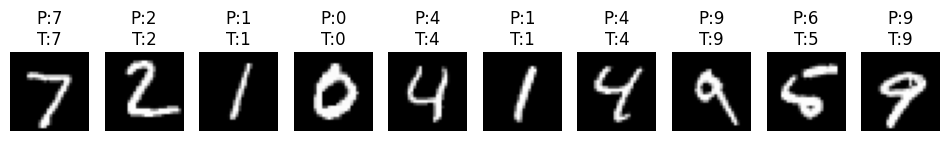

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Classifier using encoder
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.fc(features)

# Training functions
def train_autoencoder(autoencoder, train_loader, epochs=5, lr=0.01, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

    autoencoder.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in train_loader:
            imgs = imgs.view(-1, 28*28).to(device)
            outputs, _ = autoencoder(imgs)
            loss = criterion(outputs, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Autoencoder Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}")

def train_classifier(classifier, train_loader, test_loader, epochs=5, lr=0.01, device="cpu"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    for epoch in range(epochs):
        classifier.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs = imgs.view(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = classifier(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Classifier Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}")

        classifier.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = classifier(imgs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Accuracy: {100*correct/total:.2f}%")

def visualize_predictions(classifier, test_loader, device="cpu", num_images=10):
    classifier.eval()
    images, labels = next(iter(test_loader))  # Get one batch
    imgs = images.view(-1, 28*28).to(device)

    with torch.no_grad():
        outputs = classifier(imgs)
        _, preds = torch.max(outputs, 1)

    images = images[:num_images]
    preds = preds[:num_images]
    labels = labels[:num_images]

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"P:{preds[i].item()}\nT:{labels[i].item()}")
        plt.axis("off")
    plt.show()

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    transform = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

    autoencoder = Autoencoder().to(device)
    print("\nTraining Autoencoder...")
    train_autoencoder(autoencoder, train_loader, epochs=5, lr=0.001, device=device)

    classifier = Classifier(autoencoder.encoder, num_classes=10).to(device)
    print("\nTraining Classifier...")
    train_classifier(classifier, train_loader, test_loader, epochs=5, lr=0.001, device=device)

    print("\nDisplaying Predictions...")
    visualize_predictions(classifier, test_loader, device=device, num_images=10)

if __name__ == "__main__":
    main()
